# An example full-emissions run

In [1]:
import warnings
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import h5py
from tables import NaturalNameWarning
from mce.core.climate import IrmBase
from mce.core.carbon import ModelOcean, ModelLand
from mce.core.driver import Driver as DriverConv
from mce.core.forcing_ar6 import InputSeries, RfAllAR6

In [2]:
warnings.simplefilter('ignore', NaturalNameWarning)

In [3]:
path_datain = 'untracked/datain_2024.h5'
dset = 'ClimateIndicator-2024'

with h5py.File(path_datain, 'r') as f1:
    grp = f1[dset]
    grp.visititems(
        lambda name, obj:
            print('  {}: {}'.format(name, obj.attrs.get('description', '')))
            if isinstance(obj, h5py.Group) else None
    )

  GHG-Emissions-Assessment__mod1: 
  GHG-Emissions-Assessment__mod1/emis_ch4_n2o: Emissions of CH4 and N2O in 1750-2023
  forcing-timeseries: 
  forcing-timeseries/aci_cal: Forcing uncertainty ensemble related to aerosol-cloud interactions
  forcing-timeseries/ari_emitted: Reference radiative forcing by SLCF species
  forcing-timeseries/ari_emitted_std: Standard deviations of reference radiative forcing by SLCF species
  forcing-timeseries/conc_ghg: Concentrations of GHGs in 1750-2023
  forcing-timeseries/emis_co2: Emissions of CO2 in 1750-2023
  forcing-timeseries/emis_slcf: Emissions of SLCFs in 1750-2023
  forcing-timeseries/erf_contrails: Effective radiative forcing of contrails and contrail-induced cirrus in 1750-2023
  forcing-timeseries/erf_solar: Effective radiative forcing of solar irradiance in 1750-2023
  forcing-timeseries/erf_volcanic: Effective radiative forcing of volcanic activity in 1750-2023
  forcing-timeseries/scale_df: Forcing uncertainty ensemble of scale factors 

In [4]:
datain = {}

with pd.HDFStore(path_datain, mode='r') as store:
    dset1 = f'{dset}/GHG-Emissions-Assessment__mod1'
    k = 'emis_ch4_n2o'
    datain[k] = store[f'{dset1}/{k}']

    dset1 = f'{dset}/forcing-timeseries'
    for k in [
        'aci_cal', 'ari_emitted', 'ari_emitted_std',
        'conc_ghg', 'emis_co2', 'emis_slcf',
        'erf_contrails', 'erf_solar', 'erf_volcanic',
        'scale_df', 'skeie_ozone_strat', 'skeie_ozone_trop',
        'temp_obs', 'trend_solar',
        ]:
        datain[k] = store[f'{dset1}/{k}']

    dset1 = f'{dset}/inverted_emissions'
    for k in ['emis_halogens', 'emis_natural_ch4_n2o']:
        datain[k] = store[f'{dset1}/{k}']

In [5]:
def df_concat(datain, *args, **kw):
    map_name = kw.get('map_name', {})
    ret_slice = kw.get('ret_slice', False)

    data = [
        (
            datain[k].to_frame(map_name.get(k, k))
            if isinstance(datain[k], pd.Series)
            else datain[k]
        )
        for k in args
    ]
    df = pd.concat(data, axis=1)

    if ret_slice:
        jn = np.hstack([0, [df.shape[1] for df in data]]).cumsum()
        map_slc = dict(zip(
            args, [slice(jn[i-1], jn[i]) for i in range(1, len(jn))],
        ))
        return df, map_slc
    else:
        return df

In [6]:
df_emis, slc_emis = df_concat(
    datain,
    'emis_co2', 'emis_ch4_n2o', 'emis_natural_ch4_n2o',
    'emis_halogens', 'emis_slcf',
    ret_slice=True,
)

In [7]:
df_emis_co2__cumsum = (
    datain['emis_co2']
    .cumsum(axis=0)
    .rename(lambda x: x.replace('/yr', ''), axis=1, level=1)
)

In [8]:
map_erf_name = {
    f'erf_{x}': x for x in ['contrails', 'solar', 'volcanic']
}
df_erf = df_concat(datain, *list(map_erf_name), map_name=map_erf_name)

In [9]:
years = np.arange(1750, 2020)
dfin_ref = pd.concat({
    k:
    df.loc[years].T
    .rename_axis(['name', 'unit'])
    .reset_index()
    .set_index('name')
    for k, df in zip(
        ['emis', 'emis_co2__cumsum', 'conc'],
        [df_emis, df_emis_co2__cumsum, datain['conc_ghg']],
    )
}).rename_axis((None, None))

In [10]:
din = InputSeries(
    emis=df_emis,
    emis_cum=df_emis_co2__cumsum,
    erf=df_erf,
)

In [11]:
forcing = RfAllAR6(dfin_ref, din)
forcing.init__ari(datain['ari_emitted'], datain['ari_emitted_std'])
forcing.init__aci(datain['aci_cal'])
forcing.init__o3(
    datain['temp_obs'],
    datain['skeie_ozone_trop'],
    datain['skeie_ozone_strat'],
)

## Conventional driver for comparison

In [12]:
df_conc_ghg = datain['conc_ghg'].droplevel(1, axis=1)
df_emis_slcf = datain['emis_slcf'].droplevel(1, axis=1)
df_emis_co2 = datain['emis_co2'].droplevel(1, axis=1)

In [52]:
df_erf = forcing.erf__ghg(df_conc_ghg, agg_minor='halogen')
df_erf['O3'] = forcing.erf__o3(df_emis_slcf, df_conc_ghg)
df_erf['aerosol-radiation_interactions'] = (
    forcing.erf__ari(df_emis_slcf, df_conc_ghg)
)
df_erf['aerosol-cloud_interactions'] = (
    forcing.erf__aci(df_emis_slcf)
)
df_erf['land_use'] = forcing.erf__land_use(df_emis_co2)
df_erf['BC_on_snow'] = forcing.erf__bc_on_snow(df_emis_slcf)
df_erf['H2O_stratospheric'] = forcing.erf__h2o_strat(df_erf)
df_erf = pd.concat([df_erf, forcing.erf__others()], axis=1)

In [19]:
df_erf

,CO2,CH4,N2O,halogens,O3,aerosol-radiation_interactions,aerosol-cloud_interactions,land_use,BC_on_snow,H2O_stratospheric,contrails,solar,volcanic
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.097590,0.246412
1751,0.001417,0.000508,0.000074,7.958010e-10,-0.000383,0.000312,0.003303,-0.000007,-0.000366,0.000047,0.000000,0.079244,0.246420
1752,0.002833,0.001016,0.000148,1.591602e-09,-0.000318,0.000621,0.004770,-0.000020,-0.000493,0.000093,0.000000,0.049166,0.246422
1753,0.004249,0.001524,0.000222,2.387403e-09,-0.000089,0.000006,0.002776,-0.000037,-0.000379,0.000140,0.000000,0.012988,0.246423
1754,0.005665,0.002031,0.000296,3.183204e-09,0.000722,-0.001207,-0.002953,-0.000059,0.000028,0.000187,0.000000,-0.021427,-0.116729
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,2.157749,0.543972,0.208488,4.081485e-01,0.483879,-0.242714,-0.903946,-0.200000,0.080000,0.050000,0.061541,-0.022173,0.133221
2020,2.190500,0.548546,0.212231,4.087011e-01,0.466118,-0.194643,-0.791027,-0.200956,0.073532,0.050420,0.030676,-0.016969,0.096304
2021,2.221573,0.554765,0.216261,4.096640e-01,0.483894,-0.228537,-0.873016,-0.201917,0.079076,0.050992,0.036909,0.019557,0.153448
2022,2.253999,0.560691,0.220281,4.106025e-01,0.475106,-0.198474,-0.766242,-0.202876,0.069397,0.051537,0.040946,0.059393,0.095918


In [20]:
df = din.get_data('emis')
eco2 = df['CO2 FFI'] + df['CO2 AFOLU']
cco2_pi = dfin_ref.loc[('conc', 'CO2'), 1750]

drv_chk = DriverConv(
    eco2.index.values, eco2=eco2.values, 
    erf_nonco2=df_erf.drop('CO2', axis=1).sum(axis=1).values,
    kw_rfall={'ccref': cco2_pi},
    kw_ocean={'cco2_pi': cco2_pi},
)

dfout_chk = drv_chk.run({})

## Full-emissions driver

In [ ]:
class Driver:
    def __init__(self, forcing, slc_emis, dfin_ref):
        """Example driver for full-emissions runs

        Parameters
        ----------
        forcing
            Forcing object with input time series
        slc_emis
            Mapper for emissions input slicing 
        dfin_ref
            Reference input data
        """
        self.forcing = forcing
        self.slc_emis = slc_emis

        #
        # Module settings
        #
        self.init_gascycle(dfin_ref)

        cco2_pi = dfin_ref.loc[('conc', 'CO2'), 1750]

        kw_forcing = {'ccref': cco2_pi}
        kw_climate = {}
        kw_ocean = {'cco2_pi': cco2_pi}
        kw_land = {}

        self.forcing.parms.update(**kw_forcing)
        self.climate = IrmBase(**kw_climate)
        self.ocean = ModelOcean(**kw_ocean)
        self.land = ModelLand(**kw_land)

        tauj = self.climate.parms.tauj
        nl = len(tauj)
        lambk, _, akj = self.climate.get_parms_ebm()
        self.climate__lamb = lambk[0]
        self.climate__akj = akj

        #
        # State variables
        #
        self.variable_order = [
            ('climate', f'ta{k}{j}', 'K')
            for k in ['s'] + list(range(1, nl)) for j in range(nl)
        ] + [
            ('ocean', f'coc{j}', 'Gt C') for j in range(4)
        ] + [
            ('land', f'cbs{j}', 'Gt C') for j in range(4)
        ] + [
            ('conc', gas, dfin_ref.loc[('conc', gas), 'unit'])
            for gas in self.gascycle__ghgs
        ]

        comp = [
            ('climate', nl*nl),
            ('ocean', 4),
            ('land', 4),
            ('gascycle', len(self.gascycle__ghgs)),
        ]
        jn = np.hstack([0, [n for (c1, n) in comp]]).cumsum()
        self.map_y = dict(zip(
            [c1 for (c1, n) in comp],
            [slice(jn[i-1], jn[i]) for i in range(1, len(jn))],
        ))

        self.climate__y0 = np.zeros(nl*nl)
        self.ocean__y0 = np.zeros(4)
        p = self.land.parms
        self.land__y0 = p.fnpp0 * p.amp * (p.tau * p.tau)

    def init_gascycle(self, dfin_ref):
        """Gas cycle initialization

        Parameters
        ----------
        dfin_ref
            Reference input data
        """
        ghgs = []
        y0 = []
        life = []
        w2c = []

        for gas, vc in dfin_ref.loc['conc'].iterrows():
            if gas in ['CO2']:
                continue

            unit_w = dfin_ref.loc[('emis', gas), 'unit']
            ghgs.append(gas)
            y0.append(vc[1750])
            life.append(self.forcing.ghgs[gas].lifetime)
            w2c.append(
                self.forcing.weight2conc(1, unit_w[:2], gas, vc.unit)
            )

        self.gascycle__ghgs = ghgs
        self.gascycle__y0 = np.array(y0)
        self.gascycle__life = np.array(life)
        self.gascycle__w2c = np.array(w2c)

    def _erf_in(self, t, y):
        """Evaluate forcing values by category

        Parameters
        ----------
        t
            Time point
        y
            State variable values

        Returns
        -------
            Forcing values
        """
        din = self.forcing.din
        slc_emis = self.slc_emis
        map_y = self.map_y

        din_eval = {
            k: din.interp_eval(k, t)
            for k in ['emis', 'emis_cum', 'erf']
        }

        nl = len(self.climate.parms.tauj)
        takj = y[map_y['climate']].reshape((nl, nl))
        tas = takj[0, :].sum()
        coc = y[map_y['ocean']]
        hls = self.ocean.parms.hlk[0]
        catm = self.ocean.partit(coc[0], hls, tas)
        cco2 = catm * self.ocean.parms.alphaa + self.ocean.parms.cco2_pi

        erf_current = {
            'CO2': self.forcing.c2erf(cco2)
        }

        d_conc = pd.Series(
            np.hstack([cco2, y[map_y['gascycle']]]),
            index=['CO2'] + self.gascycle__ghgs,
        )

        d1 = self.forcing.erf__ghg(d_conc, agg_minor=False)
        for gas in ['CH4', 'N2O']:
            erf_current[gas] = d1[gas]

        erf_current['halogen'] = d1.drop(['CO2', 'CH4', 'N2O']).sum()

        erf_current['aerosol-radiation_interactions'] = self.forcing.erf__ari(
            din_eval['emis'].iloc[slc_emis['emis_slcf']],
            d_conc,
        )
        erf_current['aerosol-cloud_interactions'] = forcing.erf__aci(
            din_eval['emis'].iloc[slc_emis['emis_slcf']],
        )
        erf_current['land_use'] = forcing.erf__land_use(din_eval['emis_cum'])
        erf_current['BC_on_snow'] = (
            forcing.erf__bc_on_snow(
                din_eval['emis'].iloc[slc_emis['emis_slcf']],
            )
        )
        erf_current['O3'] = forcing.erf__o3(
            din_eval['emis'].iloc[slc_emis['emis_slcf']],
            d_conc,
        )

        erf_current['H2O_stratospheric'] = self.forcing.erf__h2o_strat(d1)

        # contrails, solar, and volcanic
        for k, v in din_eval['erf'].items():
            erf_current[k] = v

        return pd.Series(erf_current)

    def _emis_in_ghgs(self, t):
        """Evaluate GHGs emissions

        Parameters
        ----------
        t
            Time point

        Returns
        -------
            Emission rates (annual emissions)
        """
        din = self.forcing.din
        d1 = din.interp_eval('emis', t)
        d1['CH4'] += d1['CH4 natural']
        d1['N2O'] += d1['N2O natural']

        return d1[self.gascycle__ghgs].values

    def _func(self, t, y):
        """Evaluate the time derivative of state variables

        Parameters
        ----------
        t
            Time point
        y
            State variable values

        Returns
        -------
            Time derivative values
        """
        din = self.forcing.din
        map_y = self.map_y

        nl = len(self.climate.parms.tauj)
        takj = y[map_y['climate']].reshape((nl, nl))
        tas = takj[0, :].sum()

        coc = y[map_y['ocean']].copy()
        cbs = y[map_y['land']].copy()
        conc_ghgs = y[map_y['gascycle']].copy()

        xin = self._emis_in_ghgs
        life = self.gascycle__life
        w2c = self.gascycle__w2c

        erf = self._erf_in(t, y)
        takjdot = (
            erf.sum() / self.climate__lamb * self.climate__akj - takj
        ) / self.climate.parms.tauj

        hls = self.ocean.parms.hlk[0]
        catm = self.ocean.partit(coc[0], hls, tas)
        coc[0] -= catm
        cocdot = -np.dot(self.ocean.msyst, coc)
        d1 = din.interp_eval('emis', t)
        cocdot[0] += d1['CO2 FFI'] + d1['CO2 AFOLU']

        fert = self.land.fertmm(catm)
        tau_l = self.land.get_tau(tas)
        cbsdot = -cbs/tau_l + fert * self.land.parms.amp * tau_l
        cocdot[0] -= cbsdot.sum()

        ydot = np.hstack([
            takjdot.ravel(),
            cocdot,
            cbsdot,
            - conc_ghgs / life + xin(t) * w2c,
        ])

        return ydot

    def run(self):
        """Perform time integration

        Returns
        -------
            Dataframes of state variables and derived variables
        """
        din = self.forcing.din
        time = din.df['emis'].index.values

        y0 = np.hstack([
            self.climate__y0,
            self.ocean__y0,
            self.land__y0,
            self.gascycle__y0,
        ])
        
        frac_init_eco2 = 0.5
        d0 = din.interp_eval('emis', time[0])
        y0[self.map_y['ocean']][0] += (
            d0['CO2 FFI'] + d0['CO2 AFOLU']
        ) * frac_init_eco2 

        sol = solve_ivp(
            self._func, [time[0], time[-1]], y0, t_eval=time, max_step=1.,
        )
        self.sol = sol
        sol_y = sol.y.T.copy()

        nl = len(self.climate.parms.tauj)
        takj = sol_y[:, self.map_y['climate']].reshape((-1, nl, nl))
        tas = takj[:, 0, :].sum(axis=1)

        coc = sol_y[:, self.map_y['ocean']]
        hls = self.ocean.parms.hlk[0]
        catm = np.array([
            self.ocean.partit(coc[i, 0], hls, tas[i])
            for i in range(coc.shape[0])
        ])
        coc[:, 0] -= catm

        cbs = sol_y[:, self.map_y['land']]
        cbs -= self.land__y0

        cco2 = catm * self.ocean.parms.alphaa + self.ocean.parms.cco2_pi

        mi = pd.MultiIndex.from_tuples(self.variable_order)
        dfout = pd.DataFrame(sol_y, index=time, columns=mi)

        dfderiv = pd.DataFrame(
            np.vstack([tas, catm, cco2]),
            index=['tas', 'catm', 'cco2'],
            columns=time,
        ).T

        return dfout, dfderiv

drv = Driver(forcing, slc_emis, dfin_ref)

In [34]:
dfout, dfderiv = drv.run()

In [ ]:
from mce.util.plot_base import PlotBase
myplt = PlotBase(palette='ipcc_wg1')

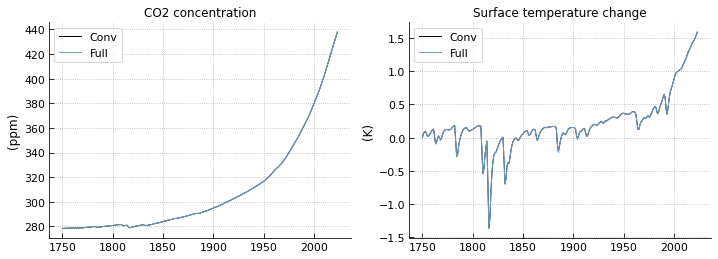

In [63]:
myplt.init_regular(2, col=2)

map_name = {
    'cco2': {'long_name': 'CO2 concentration', 'unit': 'ppm'},
    'tas': {'long_name': 'Surface temperature change', 'unit': 'K'},
}

for ax, vn in zip(myplt(), ['cco2', 'tas']):
    d0 = dfout_chk.loc[vn]
    d1 = dfderiv[vn]
    ax.plot(d0.index, d0, label='Conv')
    ax.plot(d1.index, d1, label='Full')
    ax.legend()
    ax.set_title(map_name[vn]['long_name'])
    ax.set_ylabel('({})'.format(map_name[vn]['unit']))
    ax.grid()

In [ ]:
# Note: CO2 forcing schemes are different
pd.concat([
    df_erf.loc[2023].rename('AR6'),
    drv._erf_in(2023, drv.sol.y[:, -1]).rename('MCE'),
], axis=1)

,AR6,MCE
CO2,2.285950,2.090558
CH4,0.564581,0.563421
N2O,0.223368,0.222746
halogen,0.410726,0.410741
O3,0.505961,0.505096
aerosol-radiation_interactions,-0.261172,-0.261159
aerosol-cloud_interactions,-0.910830,-0.910830
land_use,-0.203773,-0.203773
BC_on_snow,0.077565,0.077565
H2O_stratospheric,0.051894,0.051788


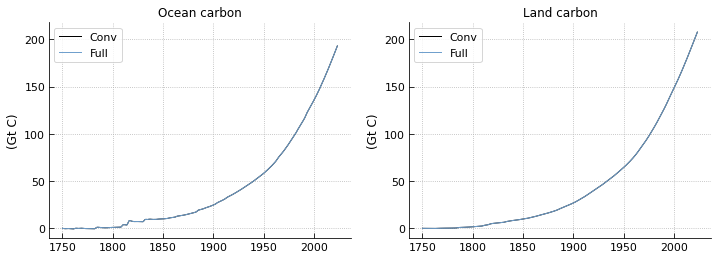

In [62]:
myplt.init_regular(2, col=2)

for ax, (vn0, vn1) in zip(
    myplt(), [('coct', 'ocean'), ('cbst', 'land')],
    ):
    d0 = dfout_chk.loc[vn0]
    d1 = dfout[vn1].sum(axis=1)
    ax.plot(d0.index, d0, label='Conv')
    ax.plot(d1.index, d1, label='Full')
    ax.legend()
    ax.set_ylabel('(Gt C)')
    ax.set_title('{} carbon'.format(vn1.capitalize()))
    ax.grid()

myplt.axis_share(axis='y')